In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import pyFAI
from scipy.interpolate import interp1d
from pyxe.peak_analysis import PeakAnalysis
import pandas as pd
%matplotlib inline

# Residual Stress Intensity Factor - $K_{res}$

## Background

The stress intensity factor for symettrical loading at the crack tip (x=a) is given by

$$K_I = \int^a_0 \! \sigma (x) \, h(a, x) \, \mathrm{d}x $$

where $\sigma(x)$ is the stress in an uncracked body and h(a,x) the weight function that is independent of $\sigma(x)$. To calculate $K_{res}$ we therefore need accurate expressions for $\sigma_{res}(x)$ and $h_{CT}(a, x)$.


## Weight Function - h(a, x)

A number of researchers have come up with weight function approximations for different geometries (see weight function notebook). In this instace we are primarily interested in the compact-tension (CT) geometry. One such approximation was provided by Fett and Munz (1997) who showed that

$$ h(a, x) = \frac{1}{\sqrt{2 \pi a}} 
\frac{1}{\sqrt{1 - \frac{x}{a}}}
\left[1 + \sum^\mu_v
\frac{A_{v, \mu}\left( \frac{a}{W}\right)^2}
{\left(1- \frac{a}{W}\right)^{\frac{3}{2}}}
\left(1 - \frac{x}{a}
\right)^{v+1}
\right]$$

where:

<img src="Images/CT_FettMunz.png" width="700"/>



In [2]:
def weight_CT_FettMunz(a, W, dx=0.005):
    """Weight function estimation as per Fett and Munz (1997).
    
    Args:
        a (float): Crack length
        W (float): Width of CT sample
        dx (float): Point spacing for calculations
        
    Returns:
        tuple: x, weight - position and weighting of point
    """
    
    A_vmu = np.array([[2.673, -8.604, 20.621, -14.635, 0.477],
                      [-3.557, 24.973, -53.398, 50.707, -11.837],
                      [1.230, -8.411, 16.957, -12.157, -0.940],
                      [-0.157, 0.954, -1.284, -0.393, 1.655]])
    
    # Remove if x[-1] if it equals a (due to zero div error)
    x = np.arange(0, a, dx)
    x = x if x[-1] != a else x[:-1]
    rho = x / a
    aW = a/W
    h1 = (2 / (np.pi * a))**0.5 * (1 / (1 - rho))**0.5
    h2 = 1 + x * 0
    for v, mu in np.ndindex(4,5):
        A = A_vmu[v, mu]
        h2 += A * aW**mu * (1 - rho)**(v + 1) / (1 - aW)**1.5
    return x, h1 * h2

We can evaluate that weight function at different a/W combinations:

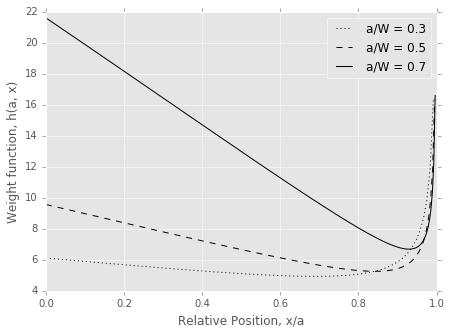

In [3]:
# Calculate the weight function at a/W = 0.3, 0.5, 0.7
plt.figure(figsize=(7, 5))
for linspec, a in zip(['k:', 'k--', 'k'], 
                      [0.3, 0.5, 0.7]): 
    x, h = weight_CT_FettMunz(a, 1, dx=0.0025)
    plt.plot(x/a, h, linspec, label='a/W = {}'.format(a))

plt.legend()
plt.xlabel('Relative Position, x/a')
plt.ylabel('Weight function, h(a, x)')
plt.show()

## Residual Stress - $\sigma_{res}$ 

We need to extract data and calculate strains and stresses from an experiment carried out at ID11. In particular, we'll interrogate data taken prior to pre-cracking a bainitic compact-tension sample subject to a compressive pre-strain. 

### Reload Diffraction Data

This data initially came as a folder containing 700+ images (Debye-Scherrer rings) and a SPEC metadata file. Positional information was scraped from the SPEC file and azimuthal integration was completed on the associated image files using pyXe and the underlying pyFAI functions. The 1D line profiles (as a function of phi) were saved to a HDF5 file and will be reloaded here.

Prior to testing a far field scan was completed with the aim of extracting valid d0/q0 values.

In [4]:
base_folder = os.path.expanduser('~/Dropbox/Synchrotron Data/id11')

In [5]:
# First extract the q0 values
q0_loc = r'd0_2_/d0_2__pyxe.h5'
file = os.path.join(base_folder, q0_loc)
q0 = PeakAnalysis(file)
q0.peak_fit(3.1, 0.5)


16 acquisition points

Progress: [####################] 100%
Total points: 576 (36 az_angles x 16 positions)
Peak not found in 0 position/detector combintions
Error limit exceeded (or pcov not estimated) 0 times


In [6]:
# Then open the real data

data_loc = r'thick4_coarse_0b/thick4_coarse_0b_pyxe.h5'
file = os.path.join(base_folder, data_loc)
data = PeakAnalysis(file)
# data.peak_fit(3.1, 0.5)

### Calculate Strain (apply q0/d0)

#### Static q0/d0

q0 = 3.0953

Unable to fit full ring at 0 out of 693 points


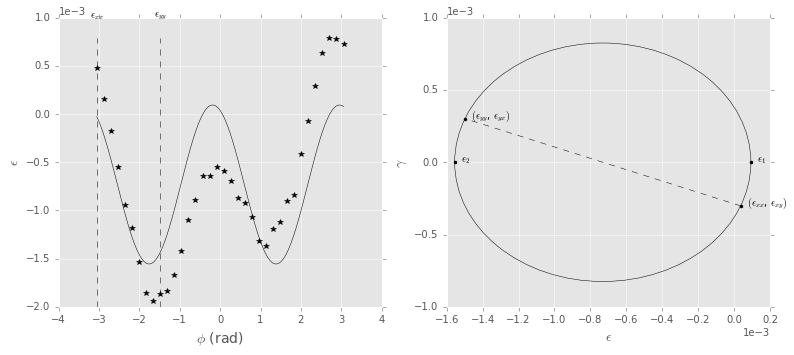

In [7]:
q0_mean = np.nanmean(q0.peaks)
print('q0 = {:.4f}'.format(q0_mean))
data.calculate_strain(q0_mean)
data.plot_strain_fit(pnt=100)

#### Apply q0 scan

Should be able to simply pass the q0 points to the test data and the phi normalised strain should be accurately calculated. The best way to test the resultant values is to plot the final strain fit, which should vary sinosoidal according to the strain transformation equation:


Unable to fit full ring at 0 out of 693 points


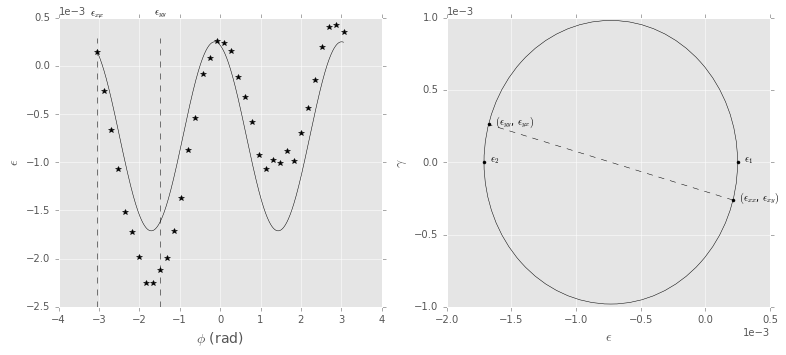

In [8]:
data.calculate_strain(q0)
data.plot_strain_fit(pnt=100)

This is better but surprisingly still not fantastically good - it raises questions over whether the d0/q0 strain free acquisition was as good as it needed to be. We should try to do better:

#### q0 vector

We'll take two approaches to this:

1. Mean q profile from all data points. If we have sampled enough material (infront and behind crack) then the total strain will sum to zero and the average profile should be equivalent to the unstrained profile.

2. Mean q profile from further field values. Use points at the furthest extent of the profile. If they are sufficiently away from the crack tip/strain field then these can be considered to be far-field strain free measurements.


Unable to fit full ring at 0 out of 693 points


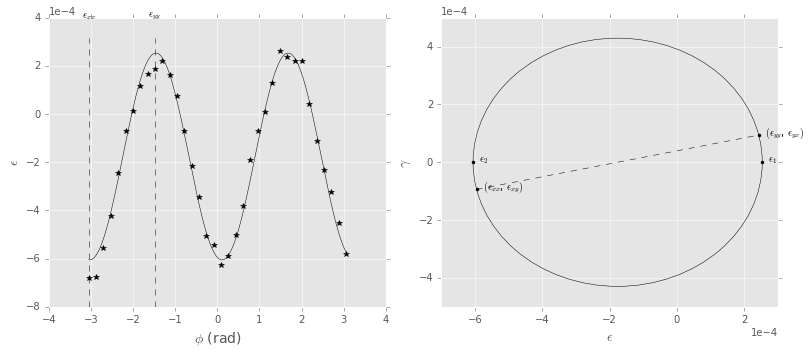

In [9]:
data.calculate_strain(np.nanmean(data.peaks, 0))
data.plot_strain_fit(pnt=200)


Unable to fit full ring at 0 out of 693 points


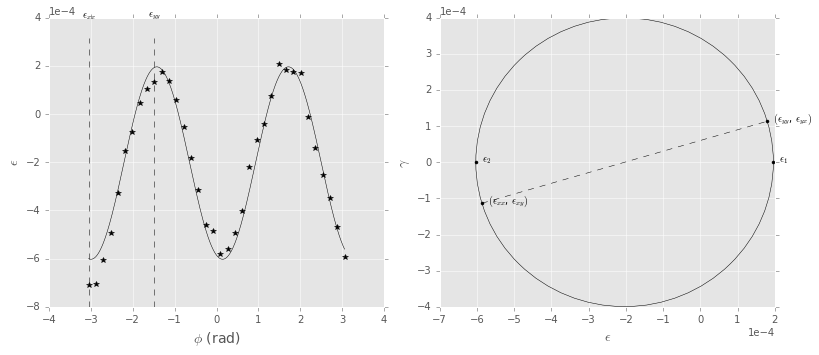

In [10]:
# Mean from final 3 rows
data.calculate_strain(np.nanmean(data.peaks[-63:], 0))
data.plot_strain_fit(pnt=200)

Both are much better - at this stage is seems more reasonable to use the far field values (although the fit is slightly worse).

### Sample Geometry

Before extracting the 1D line profile we need to align the 2D strain map, such that the x=0 reflects the same position as in the weight function calculation. To do this we first need to know the geometry of the sample:

<img src="Images/sample.png" alt="Drawing" width="400"/>

In addition to these dimensions, it is important to note that that a small notch was then added to the pre-strained sample to aid crack initiation. This was approximately 1mm in length. Taking all of this into account, the notch tip is loacted at a length, x of 11mm (main notch 10mm in length). 

### Data Transformation

With the geometry/notch in mind, lets plot the transformed (rotated/flipped/recentred) 2D strain map.

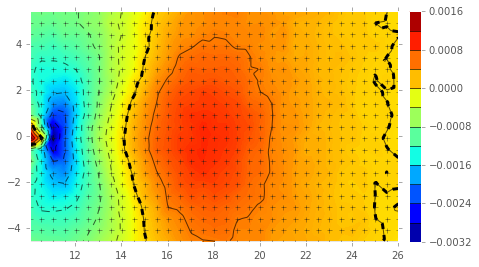

In [11]:
# Rotate and flip
data.swapaxes(0, 1)
data.flipaxis(1)
data.centre((-3.575-11, -10.7))
data.plot_slice('strain', phi=np.pi/2, figsize=(7,7))

### Stress Profile Extraction 

We need to extract the stress profile, rather than the strain profile. To do this we need to apply the materials constants - i.e. poisson's ratio and Young's modulus.

In [12]:
data.material_parameters(E=200e9, v=0.3)

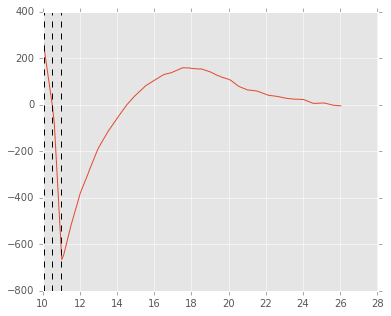

In [13]:
plt.figure(figsize=(6, 5))
x, y, d, sigma = data.extract_line(data='stress', phi=np.pi/2, pnt=(11, 0))
sigma /= 1e6
x /= 1e3
plt.plot(x * 1e3, sigma)

x0 = [i/1e3 for i in [10.05, 10.5, 11.0]]
for i in x0:
    plt.axvline(i * 1e3, ls='--', color='k')

### Clean Data

The data at approximately x = 10mm looks suspect. From the 2D map we can also see that this region also sees a peak compressive strain. This looks to be some kind of partial volume/edge effect, with the data being nonsensical (and effectively equal to 0). We can attempt to test this hypothesis by integrating the line profile. Given that the stress returns to zero in the far field, the integrated stress should also be zero. If the peak at 10mm is incorrect then this will raise the integrated stress above 0.

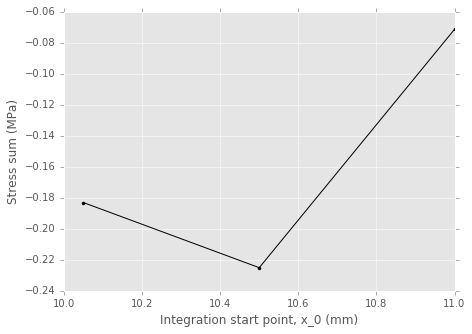

In [14]:
# Integrate from first peak, mid-point trough, and second peak
int_stress = []
for i in x0:
    valid = np.logical_and(np.isfinite(sigma), x > i) 
    int_stress.append(np.trapz(sigma[valid], x[valid]))

plt.figure(figsize=(7, 5))
plt.plot([i * 1e3 for i in x0], int_stress, 'k.-')
plt.xlabel('Integration start point, x_0 (mm)')
plt.ylabel('Stress sum (MPa)')

As expected, the integrated stress is closer to zero when the start point is taken to be the second peak. The integrated stress is 0 when x = 11.4mm, although for now we will leave x0 = 11mm. If we consider the data point to be invalid (in air) then lets make z = 0MPa when x < 11mm.

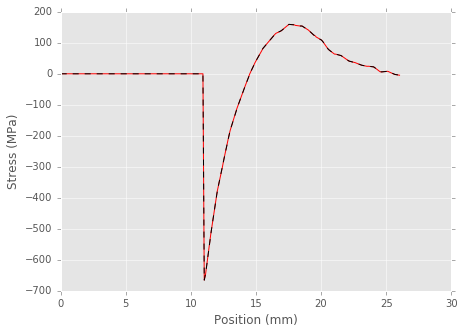

In [38]:
dx = 0.00051 / 1e3

x_new = np.concatenate((np.array([0]), x[np.isfinite(sigma)]))
sigma_new = np.concatenate((np.array([0]), sigma[np.isfinite(sigma)]))
sigma_new[x_new < 11/1e3] = 0
f = interp1d(x_new, sigma_new, 1)

# Lets check that interpolation with spacings defined by weight function calcs
x_h = np.arange(0, x_new.max(), dx)
plt.figure(figsize=(7, 5))
plt.plot(x_new * 1e3, sigma_new, 'r')
sig_b = f(x_h)
plt.plot(x_h * 1e3, sig_b, 'k--')
plt.ylabel(r'Stress (MPa)')
plt.xlabel(r'Position (mm)')

## Calculate $K_{res}$

We're now finally in a position where we can calculate $K_{res}$ as a function of position along the residual stress profile.

(10, 27)

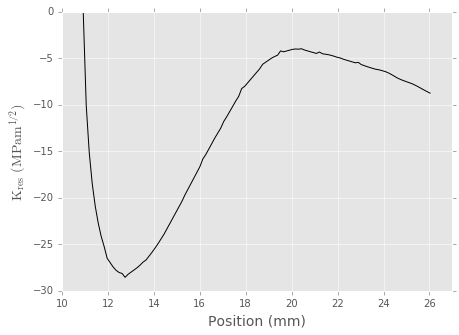

In [40]:
a = np.linspace(0, x_new.max(), 201)
K = np.nan * np.zeros_like(a)

for i, ai in enumerate(a):
    try:
        x_h, h = weight_CT_FettMunz(ai, 50/1e3, dx=dx)
        sigma_x = f(x_h)
        K[i] = np.trapz(h * sigma_x, x_h)
    except IndexError:
        pass
fig = plt.figure(figsize=(7, 5))
plt.ylabel(r'$\mathrm{K_{res}}$ $\mathrm{(MPam^{1/2})}$', size=14)
plt.xlabel(r'Position (mm)', size=14)
plt.plot(a * 1e3, K, 'k')
plt.xlim([10, 27])

## Save Data

In [41]:
f_end = r'~/Dropbox/Papers, Proposals and Presentations/Papers/ECF21/Figures'
path = os.path.join(os.path.expanduser(f_end), r'k_res_tens.csv')
print(path)
sig_a = f(a)
np.savetxt(path, (a, sig_a, K), delimiter=',')

C:\Users\casim/Dropbox/Papers, Proposals and Presentations/Papers/ECF21/Figures\k_res_tens.csv


In [30]:
len(K)

101